230510 수요일 군AI 실습 자료입니다.   
본 내용은 IIPL (Intelligent Information Processing Lab) 소속 석사과정 유승욱 조교가 작성하였습니다.   
참고 자료: MIT Introduction to Deep Learning 6.S191: Lecture 4

> Lecture 4 
- Set Device & Datasets
- Variational Autoencoders (VAE)
- Generative Adversarial Networks (GAN)

### Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

### Set Device & Datasets

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

using device: cuda


In [ ]:
""" TODO: Custom image transformation """

# Custom image datasets
custom_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [ ]:
# Load MNIST datasets
batch_size = 256
train_dataset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/MNIST',
                                           train=True,
                                           download=True,
                                           transform=custom_transform)
test_dataset  = torchvision.datasets.MNIST(root='/content/drive/MyDrive/MNIST',
                                           train=False,
                                           download=True,
                                           transform=custom_transform)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

image type: <class 'torch.Tensor'>
image shape: torch.Size([3, 32, 242])



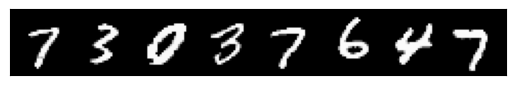

In [ ]:
# Visualize MNIST images
sample, label = next(iter(train_loader))

def imshow_grid(img):
  img = torchvision.utils.make_grid(img)
  print('image type: {}'.format(type(img)))
  print('image shape: {}\n'.format(img.shape))

  plt.imshow(img.permute(1, 2, 0))
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  plt.show()

imshow_grid(sample[0:8])

### Variational Autoencoders (VAE)

In [ ]:
""" TODO: Make your Variational Autoencoders using Pytorch """

class VAE(nn.Module):
  def __init__(self, image_size, hidden_dim1, hidden_dim2, latent_dim):
    super(VAE, self).__init__()

    self.fc1 = nn.Linear(image_size, hidden_dim1)
    self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.fc3_1 = nn.Linear(hidden_dim2, latent_dim)
    self.fc3_2 = nn.Linear(hidden_dim2, latent_dim)

    self.fc4 = nn.Linear(latent_dim, hidden_dim2)
    self.fc5 = nn.Linear(hidden_dim2, hidden_dim1)
    self.fc6 = nn.Linear(hidden_dim1, image_size)


  def encode(self, x):
    h1 = F.relu(self.fc1(x))
    h2 = F.relu(self.fc2(h1))
    h3_1 = self.fc3_1(h2)
    h3_2 = self.fc3_2(h2)
    return h3_1, h3_2


  def decode(self, z):
    h4 = F.relu(self.fc4(z))
    h5 = F.relu(self.fc5(h4))
    h6 = torch.sigmoid(self.fc6(h5))
    return h6


  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + std * eps


  def forward(self, x):
    mu, logvar = self.encode(x.view(-1, 784))
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [ ]:
""" TODO: Define your VAE model """

# Define VAE model
hidden_dim1 = 512
hidden_dim2 = 256
vae_model = VAE(28*28, hidden_dim1, hidden_dim2, 2).to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

In [ ]:
# Define VAE loss function
def loss_func(recon_x, x, mu, logvar):
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
  return KLD + BCE

In [ ]:
# Train VAE model
def train(epoch, model, train_loader, optimizer):
  model.train()
  train_loss = 0

  for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    optimizer.zero_grad()

    recon_batch, mu, logvar = model(images)

    loss = loss_func(recon_batch, images, mu, logvar)
    loss.backward()
    train_loss += loss.item()

    optimizer.step()

    if batch_idx % 100 == 0:
      print('\tTrain Epoch/Batch: {}/{} | Train Loss: {}'.format(\
          epoch, batch_idx, loss.item() / len(images)))

In [ ]:
# Test VAE model
def test(model, test_loader):
  model.eval()
  test_loss = 0

  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
      images = images.to(device)

      recon_batch, mu, logvar = model(images)
      
      loss = loss_func(recon_batch, images, mu, logvar)
      test_loss += loss.item()

      # Compare VAE's reconstruction with test dataset
      if batch_idx == 0:
        n = min(images.size(0), 8)
        compare = torch.cat([images[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]])
        grid = torchvision.utils.make_grid(compare.cpu())

In [ ]:
""" TODO: Train and test your VAE model """

# Train and test with VAE model
epochs = 10

for epoch in tqdm(range(epochs)):
  train(epoch+1, vae_model, train_loader, optimizer)
  test(vae_model, test_loader)
  print('\n')

  0%|          | 0/10 [00:00<?, ?it/s]

	Train Epoch/Batch: 1/0 | Train Loss: 543.9908447265625
	Train Epoch/Batch: 1/100 | Train Loss: -26724.380859375
	Train Epoch/Batch: 1/200 | Train Loss: -45006.33203125


	Train Epoch/Batch: 2/0 | Train Loss: -45602.16015625
	Train Epoch/Batch: 2/100 | Train Loss: -50229.9765625
	Train Epoch/Batch: 2/200 | Train Loss: -51226.47265625


	Train Epoch/Batch: 3/0 | Train Loss: -52552.85546875
	Train Epoch/Batch: 3/100 | Train Loss: -53455.109375
	Train Epoch/Batch: 3/200 | Train Loss: -52455.828125


	Train Epoch/Batch: 4/0 | Train Loss: -54548.78515625
	Train Epoch/Batch: 4/100 | Train Loss: -53228.0703125
	Train Epoch/Batch: 4/200 | Train Loss: -54083.890625


	Train Epoch/Batch: 5/0 | Train Loss: -51792.35546875
	Train Epoch/Batch: 5/100 | Train Loss: -54556.15234375
	Train Epoch/Batch: 5/200 | Train Loss: -54930.3125


	Train Epoch/Batch: 6/0 | Train Loss: -54849.50390625
	Train Epoch/Batch: 6/100 | Train Loss: -53683.9140625
	Train Epoch/Batch: 6/200 | Train Loss: -55129.90625


	Trai

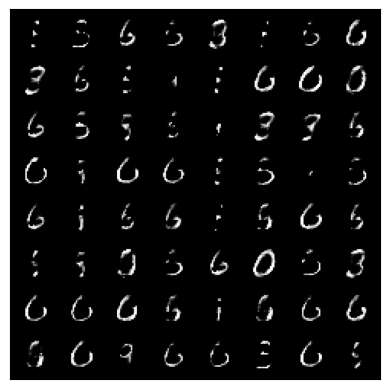

In [ ]:
# Convert latent vector to image by your trained VAE model
def latent2image(model):
  with torch.no_grad():
    sample = torch.randn(64, 2).to(device)
    recon_image = model.decode(sample).cpu()
    grid = torchvision.utils.make_grid(recon_image.view(64, 1, 28, 28))

    plt.imshow(grid.permute(1, 2, 0))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()

latent2image(vae_model)

### Generative Adversarial Networks (GAN)

In [ ]:
""" TODO: Define your own hyper-parameters for GAN """

# Define hyper-paremeters 
noise_dim  = 100
hidden_dim = 256
lr_g, lr_d = 0.0002, 0.0002

In [ ]:
# Initialize paraemeters in model
def init_params(model):
  for p in model.parameters():
    if p.dim() > 1: nn.init.xavier_normal_(p)
    else: nn.init.uniform_(p, 0.1, 0.2)

In [ ]:
""" TODO: Make your Generator for GAN using Pytorch """

# Make a noise vector z
def make_noise_vector(batch_size, noise_dim):
  return torch.randn(batch_size, noise_dim, device=device)


# Generator model
Generator = nn.Sequential(
    nn.Linear(noise_dim, hidden_dim),
    nn.ReLU(),
    nn.Dropout(0.1),
    
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Dropout(0.1),

    nn.Linear(hidden_dim, 28*28),
    nn.Tanh()
).to(device)

init_params(Generator)
optimizer_g = optim.Adam(Generator.parameters(), lr=lr_g)

In [ ]:
# Visualize images
def imshow(img):
  img = (img+1)/2
  img = img.squeeze()
  np_img = img.numpy()
  plt.imshow(np_img, cmap='gray')
  plt.show()

def imshow_grid(img):
  img = utils.make_grid(img.cpu().detach())
  img = (img+1)/2
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1,2,0)))
  plt.show()

noise vector z: tensor([[-0.3060,  1.4449,  1.0665,  0.0798, -0.1268, -0.4855, -0.6036, -0.4322,
          1.0801, -0.5971,  0.1652,  0.7226, -0.2041,  1.8739, -1.2901,  1.4200,
          1.1749,  0.0204, -0.0611,  0.7676, -0.3069,  2.2351, -0.1961,  0.5473,
          0.8512, -0.2228, -0.7406, -0.6526, -0.0321, -0.5780,  0.8118, -1.5990,
          1.4640,  0.6866, -1.2644, -0.8308,  0.6484,  1.1025,  0.9301, -0.3192,
          0.5442,  0.2764,  0.6217, -1.7908, -1.2359, -0.1439, -1.3192,  0.5212,
         -0.5040, -1.7935, -0.9762,  0.4512, -1.5442, -0.4719,  0.8181, -0.3018,
         -0.8326,  1.4221,  0.0559, -0.0485,  1.7868,  0.4245,  1.4058, -0.7320,
          0.2023, -0.5133, -0.9548, -1.2741,  0.0501,  0.6165,  0.5801,  0.9931,
          1.3734,  0.7414, -0.0944, -0.1243,  1.3566,  1.0123, -0.7125, -0.1393,
         -0.2878,  0.4336, -1.0100,  1.2305,  0.0598,  1.7690,  0.2530, -0.9254,
          1.3844,  0.8294,  0.6206, -1.0145,  1.4659,  0.8877, -1.7300,  1.5628,
         -0.

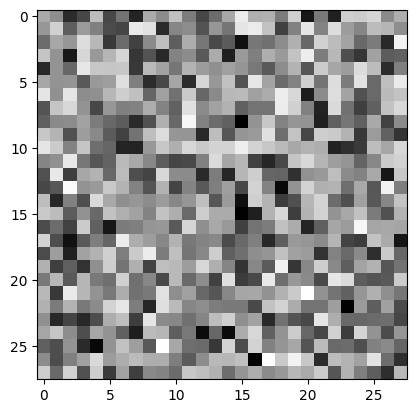

In [ ]:
# Make a fake image from your Generator
z = make_noise_vector(1, noise_dim)
print('noise vector z: {}\n'.format(z))

fake_image = Generator(z).view(-1, 28, 28)
print('fake image from z:')
imshow(fake_image.squeeze().cpu().detach())

In [ ]:
""" TODO: Make your Discriminator for GAN using Pytorch """

# Discriminator model
Discriminator = nn.Sequential(
    nn.Linear(28*28, hidden_dim),
    nn.LeakyReLU(),
    nn.Dropout(0.1),

    nn.Linear(hidden_dim, hidden_dim),
    nn.LeakyReLU(),
    nn.Dropout(0.1),

    nn.Linear(hidden_dim, 1),
    nn.Sigmoid()
).to(device)

init_params(Discriminator)
optimizer_d = optim.Adam(Discriminator.parameters(), lr=lr_d)

In [ ]:
# Check each Tensor's shape
print('fake image from noise vector -> generator        : {}'.format(
    Generator(z).shape))
print('checks whether it is real or not by discriminator: {}'.format(
    Discriminator(Generator(z)).shape))

fake image from noise vector -> generator        : torch.Size([1, 784])
checks whether it is real or not by discriminator: torch.Size([1, 1])


In [ ]:
# Train Discriminator & Generator model
def train(generator, discriminator, optim_g, optim_d, train_loader):
  generator.train()
  discriminator.train()

  for batch_idx, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    # Optimize Discriminator
    optim_d.zero_grad()

    p_real = discriminator(images.view(-1, 28*28))
    p_fake = discriminator(generator(make_noise_vector(batch_size, noise_dim)))

    bce_loss = nn.BCELoss()
    loss_d = bce_loss(p_real, torch.ones_like(p_real).to(device)) + \
              bce_loss(p_fake, torch.zeros_like(p_fake).to(device))

    loss_d.backward()
    optim_d.step()


    # Optimize Generator
    optim_g.zero_grad()

    p_fake = discriminator(generator(make_noise_vector(batch_size, noise_dim)))

    bce_loss = nn.BCELoss()
    loss_g = bce_loss(p_fake, torch.ones_like(p_fake).to(device))

    loss_g.backward()
    optim_g.step()

In [ ]:
# Test Discriminator & Generator model
def test(generator, discriminator, test_loader):
  generator.eval()
  discriminator.eval()
  p_real, p_fake = 0., 0.

  for batch_idx, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)

    with torch.autograd.no_grad():
      p_real += (torch.sum(discriminator(images.view(-1, 28*28))).item()) / 10000.
      p_fake += (torch.sum(discriminator(generator(make_noise_vector(batch_size, noise_dim)))).item()) / 10000.

  return p_real, p_fake

  0%|          | 0/60 [00:00<?, ?it/s]

	Epoch: 20 | p_real: 0.9902099394798277, p_fake: 0.031478321313858026


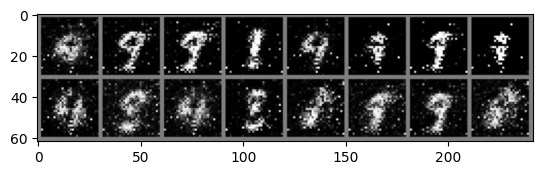

	Epoch: 40 | p_real: 0.840490733718872, p_fake: 0.16718622169494626


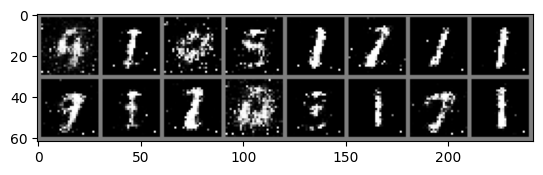

	Epoch: 60 | p_real: 0.7421429229736327, p_fake: 0.16414184150695796


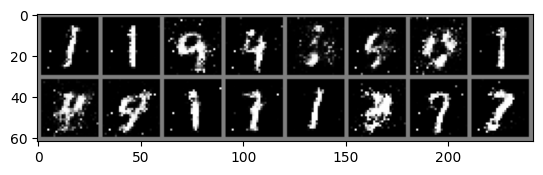

In [ ]:
# Train and test with GAN model
epochs    = 60
p_real_trace, p_fake_trace = [], []

for epoch in tqdm(range(epochs)):
  train(Generator, Discriminator, optimizer_g, optimizer_d, train_loader)
  p_real, p_fake = test(Generator, Discriminator, test_loader)

  p_real_trace.append(p_real)
  p_fake_trace.append(p_fake)

  if (epoch+1) % 20 == 0:
    print('\tEpoch: {} | p_real: {}, p_fake: {}'.format(
        epoch+1, p_real, p_fake))
    imshow_grid(Generator(make_noise_vector(16, noise_dim)).view(-1, 1, 28, 28))

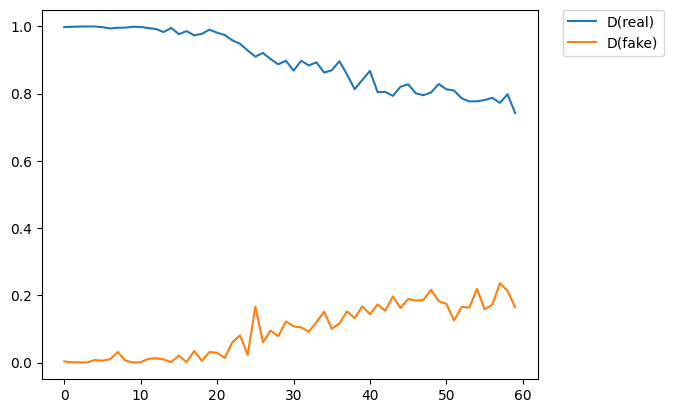

In [ ]:
# Check how my GAN model discriminates real & fake iamge
plt.plot(p_real_trace, label='D(real)')
plt.plot(p_fake_trace, label='D(fake)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

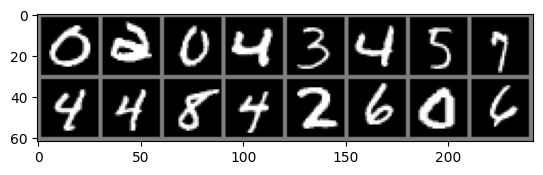

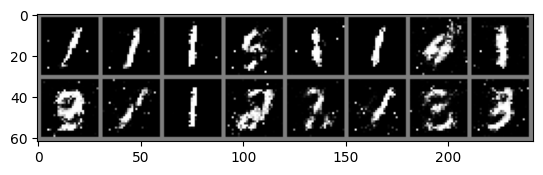

In [ ]:
# Try on test dataset
vis_loader = torch.utils.data.DataLoader(test_dataset, 16, True)
images_vis, labels_vis = next(iter(vis_loader))
imshow_grid(images_vis)

imshow_grid(Generator(make_noise_vector(16, 100)).view(-1, 1, 28, 28))